# Final Project

## Do people name their children after characters from movies or TV shows? If either, what is the nature of the character after whom they are named?

#### Setting up the notebook
First, import libraries and set up jupyter magic for matplotlib and gcloud bigquery

In [75]:
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%reload_ext google.cloud.bigquery

#### Establishing BiqQuery Credentials and Environment

In [2]:
credentials = service_account.Credentials.from_service_account_file('keys/names_proj_key.json')
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="keys/names_proj_key.json"
client = bigquery.Client(credentials=credentials, project='628610721')

#### Set query for USA names dataset to a dateframe (post-1970 names)

In [79]:
df = client.query('''
    SELECT name
    , gender
    , year
    , sum(number) as number
    FROM
        `bigquery-public-data.usa_names.usa_1910_current`
    WHERE
        year > 1960
    GROUP BY name, year, gender
    ORDER BY name, year
''').to_dataframe()

In [80]:
df.head()

,name,gender,year,number
0,Aaban,M,2013,6
1,Aaban,M,2014,6
2,Aadan,M,2008,12
3,Aadan,M,2009,6
4,Aadan,M,2014,5


In [81]:
df.tail()

,name,gender,year,number
25938,Zyriah,F,2013,7
25939,Zyriah,F,2014,6
25940,Zyriah,F,2016,5
25941,Zyron,M,2015,5
25942,Zyshonne,M,1998,5


In [82]:
df.shape

(425943, 4)

In [83]:
df.dtypes

name      object
gender    object
year       int64
number     int64
dtype: object

### Data Dictionary
#### Movie/TV Show relevance:
- 0: Not a relevant year
- 1-n: 1 - nth year(s) of popularity
#### Character type:
- 0: None
- 1: Supporting
- 2: Lead
#### Genre:
- 0: None
- 1: Drama
- 2: Fantasy
#### Movie/TV Show:
- 0: None
- 1: The Sopranos
- 2: Game of Thrones
- 3: Harry Potter
- 4: Twilight
- 5: Sex and the City
#### Show/movie years:
- The Sopranos: 1999-2007
- Game of Thrones: 2011-2018
- Harry Potter: 2001-2011
- Twilight: 2008-2012
- Sex and the City: 1998-2004
#### Create several lists: one for all character names being evaluated, one for each show/movie, one each for lead and supporting roles of character being evaluated 

In [8]:
some_chars = ['Brienne','Carrie','Samantha','Charlotte','Miranda','James','Aidan','Anthony','Tony','Christopher','Carmela','Meadow','Tyrion','Arya','Sansa','Khaleesi','Daenerys','Jaime','Harry','Ron','Harold','Ronald','Hermione','Ginny','Virginia','Jacob','Edward','Bella','Alice','Isabella','Chris']
satc = ['Carrie','Samantha','Charlotte','Miranda','James','Aidan']
sops = ['Anthony','Tony','Christopher','Carmela','Meadow','Chris']
got = ['Brienne','Tyrion','Arya','Sansa','Khaleesi','Daenerys','Jaime']
hp = ['Harry','Ron','Harold','Ronald','Hermione','Ginny','Virginia']
twi = ['Jacob','Edward','Bella','Alice','Isabella']
lead = ['Anthony','Tony','Khaleesi','Daenerys','Harry','Harold','Jacob','Edward','Bella','Isabella']
supp = ['James','Aidan','Brienne','Christopher','Carmela','Meadow','Tyrion','Arya','Sansa','Ron','Ronald','Hermione','Ginny','Virginia','Alice']

#### Filter whole dataframe to evaluate only the character names since 1970 (to provide some time of evaluating the name trends without the popularity of the shows to propel the names

In [84]:
df_shows = df[df['name'].isin(hp)]

#### Check the shape of the dataframe

In [85]:
df_shows.shape

(365, 4)

#### Create a new column making a dictionary for the names in some_chars and apply it to the names column

In [11]:
some_char_names = {
 'Brienne':0,
 'Carrie':1,
 'Samantha':3,
 'Charlotte':4,
 'Miranda':5,
 'James':6,
 'Aidan':7,
 'Anthony':8,
 'Tony':9,
 'Christopher':10,
 'Carmela':11,
 'Meadow':12,
 'Tyrion':13,
 'Arya':14,
 'Sansa':15,
 'Khaleesi':16,
 'Daenerys':17,
 'Jaime':18,
 'Harry':19,
 'Ron':20,
 'Harold':21,
 'Ronald':22,
 'Hermione':23,
 'Ginny':24,
 'Virginia':25,
 'Jacob':26,
 'Edward':27,
 'Bella':28,
 'Alice':29,
 'Isabella':30,
 'Chris':31
}

df_shows['new_names'] = df_shows['name'].map(some_char_names)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Create a new column to quantify the popularity of character names during the years of the individual show/movie relevance

In [12]:
def origin(row):
    if (1999 <= row['year'] <= 2007) and (row['name'] in (sops)):
        return 1
    elif (2011 <= row['year'] <= 2018) and (row['name'] in (got)):
        return 2
    elif (2001 <= row['year'] <= 2011) and (row['name'] in (hp)):
        return 3
    elif (2008 <= row['year'] <= 2012) and (row['name'] in (twi)):
        return 4
    elif (1998 <= row['year'] <= 2004) and (row['name'] in (satc)):
        return 5
    else:
        return 0
df_shows['movshow'] = df_shows.apply(lambda row: origin(row), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Create a new column to quantify the genre of the names and related shows/movies

In [13]:
def genre(row):
    if (1999 <= row['year'] <= 2007) and (row['name'] in (sops)):
        return 1
    elif (2011 <= row['year'] <= 2018) and (row['name'] in (got)):
        return 2
    elif (2001 <= row['year'] <= 2011) and (row['name'] in (hp)):
        return 2
    elif (2008 <= row['year'] <= 2012) and (row['name'] in (twi)):
        return 2
    elif (1998 <= row['year'] <= 2004) and (row['name'] in (satc)):
        return 1
    else:
        return 0
df_shows['genre'] = df_shows.apply(lambda row: genre(row), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Create a column that shows whether the character name is that of a lead or supporting character

In [14]:
def role_type(row):
    if (row['movshow'] != 0) and (row['name'] in (lead)):
        return 2
    elif (row['movshow'] != 0) and (row['name'] in (supp)):
        return 1
    else:
        return 0
df_shows['role'] = df_shows.apply(lambda row: role_type(row), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Create a column to show the first estimation of relevance (for every year from beginning to end of show/movie, add 1)

In [15]:
def sops_pop_year(row):
    if row['name'] in (sops) and (row['year']<=1998):
        return 0
    elif row['name'] in (sops) and (row['year']==1999):
        return 1
    elif row['name'] in (sops) and (row['year']==2000):
        return 2
    elif row['name'] in (sops) and (row['year']==2001):
        return 3
    elif row['name'] in (sops) and (row['year']==2002):
        return 4
    elif row['name'] in (sops) and (row['year']==2003):
        return 5
    elif row['name'] in (sops) and (row['year']==2004):
        return 6
    elif row['name'] in (sops) and (row['year']==2005):
        return 7
    elif row['name'] in (sops) and (row['year']==2006):
        return 8
    elif row['name'] in (sops) and (row['year']==2007):
        return 9
    else:
        return 0
df_shows['sops_rel'] = df_shows.apply(lambda row: sops_pop_year(row), axis=1)

def satc_pop_year(row):
    if row['name'] in (satc) and (row['year']<=1998):
        return 0
    elif row['name'] in (satc) and (row['year']==1999):
        return 1
    elif row['name'] in (satc) and (row['year']==2000):
        return 2
    elif row['name'] in (satc) and (row['year']==2001):
        return 3
    elif row['name'] in (satc) and (row['year']==2002):
        return 4
    elif row['name'] in (satc) and (row['year']==2003):
        return 5
    elif row['name'] in (satc) and (row['year']==2004):
        return 6
    else:
        return 0
df_shows['satc_rel'] = df_shows.apply(lambda row: satc_pop_year(row), axis=1)
        
def got_pop_year(row):
    if row['name'] in (got) and (row['year']==2011):
        return 1
    elif row['name'] in (got) and (row['year']==2012):
        return 2
    elif row['name'] in (got) and (row['year']==2013):
        return 3
    elif row['name'] in (got) and (row['year']==2014):
        return 4
    elif row['name'] in (got) and (row['year']==2015):
        return 5
    elif row['name'] in (got) and (row['year']==2016):
        return 6
    elif row['name'] in (got) and (row['year']==2017):
        return 7
    else:
        return 0
df_shows['got_rel'] = df_shows.apply(lambda row: got_pop_year(row), axis=1)

def hp_pop_year(row):
    if row['name'] in (hp) and (row['year']==2001):
        return 1
    elif row['name'] in (hp) and (row['year']==2002): 
        return 2
    elif row['name'] in (hp) and (row['year']==2003):
        return 3
    elif row['name'] in (hp) and (row['year']==2004):
        return 4
    elif row['name'] in (hp) and (row['year']==2005):
        return 5
    elif row['name'] in (hp) and (row['year']==2006):
        return 6
    elif row['name'] in (hp) and (row['year']==2007):
        return 7
    elif row['name'] in (hp) and (row['year']==2008):
        return 8
    elif row['name'] in (hp) and (row['year']==2009):
        return 9
    elif row['name'] in (hp) and (row['year']==2010):
        return 10
    elif row['name'] in (hp) and (row['year']==2011):
        return 11
    else:
        return 0
df_shows['hp_rel'] = df_shows.apply(lambda row: hp_pop_year(row), axis=1)

def twi_pop_year(row):
    if row['name'] in (twi) and (row['year']==2008):
        return 1
    elif row['name'] in (twi) and (row['year']==2009):
        return 2
    elif row['name'] in (twi) and (row['year']==2010):
        return 3
    elif row['name'] in (twi) and (row['year']==2011):
        return 4
    elif row['name'] in (twi) and (row['year']==2012):
        return 5
    else:
        return 0

df_shows['twi_rel'] = df_shows.apply(lambda row: twi_pop_year(row), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

#### Create a column to show the second estimation of relevance (1 for popular year, 0 for not popular)

In [16]:
def sops_pop_year(row):
    if row['name'] in (sops) and (1999 <= row['year'] <= 2007):
        return 1
    else:
        return 0
df_shows['sops_rel_1'] = df_shows.apply(lambda row: sops_pop_year(row), axis=1)
        
def hp_pop_year(row):
    if row['name'] in (hp) and (2001<= row['year'] <= 2011):
        return 1
    else:
        return 0
df_shows['hp_rel_1'] = df_shows.apply(lambda row: hp_pop_year(row), axis=1)

def got_pop_year(row):
    if row['name'] in (got) and (2011<= row['year'] <= 2018):
        return 1
    else:
        return 0
df_shows['got_rel_1'] = df_shows.apply(lambda row: got_pop_year(row), axis=1)

def twi_pop_year(row):
    if row['name'] in (twi) and (2008 <= row['year'] <= 2012):
        return 1
    else:
        return 0
df_shows['twi_rel_1'] = df_shows.apply(lambda row: twi_pop_year(row), axis=1)

def satc_pop_year(row):
    if row['name'] in (satc) and (1998 <= row['year'] <= 2004):
        return 1
    else:
        return 0
df_shows['satc_rel_1'] = df_shows.apply(lambda row: satc_pop_year(row), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.htm

#### Create a new column that translates gender values to binary

In [18]:
def new_gend(row):
    if row['gender'] == 'M':
        return 0
    elif row['gender'] == 'F':
        return 1
    else:
        return NaN

df_shows['new_gender'] = df_shows.apply(lambda row: new_gend(row), axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Create a column that shows rate of change of character names over year. Apply it to the dataframe and make a new column of the derivatives

In [19]:
def deriv_finder(df):
    v = [df[x].values.tolist() for x in df.columns]
    i = 0
    lst = []
    for i in range(0,len(v[0])):
        if v[0][i] == v[0][i-1] and (v[2][i-1])+1 == v[2][i]:
            pct_chg = ((v[3][i]-v[3][i-1])/(v[3][i-1]))
            lst.append(pct_chg)
            i += 1
        elif v[0][i] != v[0][i-1]:
            lst.append(0.0)
        else:
            lst.append(0.0)
    #new_df = pd.merge(df, lst)
    print(lst)

In [20]:
deriv_finder(df_shows)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8666666666666667, 0.14285714285714285, -0.28125, 0.08695652173913043, 0.68, 0.9523809523809523, 0.3048780487804878, 0.9719626168224299, 0.3696682464454976, 0.0, 0.0, 0.0, -0.9123931623931624, 0.0, -0.9797225186766275, 0.0, -0.9765037593984962, 0.0, 0.23469387755102042, 0.0, 1.3448275862068966, 0.0, -0.9551427276846398, 0.0, 0.40875912408759124, 0.0, -0.08759124087591241, 0.0, 0.44735327963176064, 0.0, 55.12, 0.0, 66.29655172413793, 0.0, 0.23595505617977527, 0.0, -0.16085309946182977, 0.0, 129.40677966101694, 0.0, -0.5087719298245614, 0.0, -0.2591253443526171, 0.0, -0.2857142857142857, 0.0, -0.13265031005661904, -0.9984457569163817, 0.0, -0.14759036144578314, -0.006183745583038869, -0.06755555555555555, -0.1873212583412774, 0.0, -0.21105866486850977, -0.0017094017094017094, -0.007705479452054794, -0.10785159620362382, -0.11411992263056092, -0.08733624454148471, -0.09688995215311005, -0.006622516556291391, -0.06266666666666666, 0.008534850640113

In [21]:
lst = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8666666666666667, 0.14285714285714285, -0.28125, 0.08695652173913043, 0.68, 0.9523809523809523, 0.3048780487804878, 0.9719626168224299, 0.3696682464454976, 0.0, 0.0, 0.0, -0.9123931623931624, 0.0, -0.9797225186766275, 0.0, -0.9765037593984962, 0.0, 0.23469387755102042, 0.0, 1.3448275862068966, 0.0, -0.9551427276846398, 0.0, 0.40875912408759124, 0.0, -0.08759124087591241, 0.0, 0.44735327963176064, 0.0, 55.12, 0.0, 66.29655172413793, 0.0, 0.23595505617977527, 0.0, -0.16085309946182977, 0.0, 129.40677966101694, 0.0, -0.5087719298245614, 0.0, -0.2591253443526171, 0.0, -0.2857142857142857, 0.0, -0.13265031005661904, -0.9984457569163817, 0.0, -0.14759036144578314, -0.006183745583038869, -0.06755555555555555, -0.1873212583412774, 0.0, -0.21105866486850977, -0.0017094017094017094, -0.007705479452054794, -0.10785159620362382, -0.11411992263056092, -0.08733624454148471, -0.09688995215311005, -0.006622516556291391, -0.06266666666666666, 0.008534850640113799, 0.021156558533145273, -0.09944751381215469, 0.009202453987730062, -0.030395136778115502, 0.04231974921630094, 0.09323308270676692, 0.0921595598349381, -0.11586901763224182, 0.0, 90.5, -0.05327868852459016, -0.07503607503607504, 0.0015600624024961, -0.1526479750778816, 0.014705882352941176, -0.007246376811594203, -0.005474452554744526, 0.01651376146788991, 0.08483754512635379, 0.05490848585690516, -0.07255520504731862, 0.04931972789115646, 0.08427876823338736, 0.06278026905829596, 0.015471167369901548, 0.11357340720221606, 0.15796019900497513, 0.07411385606874328, 0.24, 0.4314516129032258, 0.23211267605633804, 0.14311842706904435, 0.1708, 0.040314314998291766, 0.11986863711001643, 0.07859237536656892, 0.03099510603588907, 0.0, 0.0, 206.9047619047619, 0.0, 179.4065934065934, 0.0, -0.1724137931034483, 0.0, 0.006283169645580431, 0.0, -0.0375, 0.0, 0.011256922706477246, 0.0, 170.58163265306123, 0.0, 195.97752808988764, 0.0, 0.21839080459770116, 0.0, -0.9954011241696474, 0.0, -0.9949391622698396, 0.0, -0.9932803909590715, 0.0, 0.0567797892188997, 0.0, 219.85, 0.0, 153.57042253521126, 0.0, 0.06535947712418301, 0.0, 0.022191460829692432, 0.0, 195.93548387096774, 0.0, -0.2976190476190476, 0.0, -0.025324027916251247, 0.0, 398.3965517241379, 0.0, 0.017543859649122806, 0.0, -0.9974753270599036, 0.0, -0.9977776748923561, 0.0, -0.99794921875, 0.0, -0.02316734136467834, 0.0, 1634.8333333333333, 0.0, 0.2222222222222222, 0.0, -0.9984591679506933, 0.0, -0.9994910423452769, 0.0, -0.9989864693660366, 0.0, -0.9994893790849673, 0.0, -0.026856632247815728, 0.0, 624.0967741935484, 0.0, 3232.5, 0.011648884078140301, 0.0, 0.0, 0.0, -0.11337067043662662, -0.9996933644057402, 0.0, -0.07903402854006586, -0.07487905770174577, -0.07086017430845017, -0.05619902120717781, -0.08236107510154697, -0.0722358259559239, -0.10648665110141102, 0.0, 0.0, -0.1, 0.0, 0.3333333333333333, 0.16666666666666666, 0.21428571428571427, 0.058823529411764705, -0.2222222222222222, -0.14285714285714285, -0.3333333333333333, 1.375, -0.3157894736842105, 0.0, 0.38461538461538464, -0.16666666666666666, 0.26666666666666666, -0.2631578947368421, 0.0, 0.21428571428571427, 0.0, 0.40476190476190477, 0.0, 1.0434782608695652, 0.0, -0.3194444444444444, 0.0, 0.6027397260273972, 0.0, 0.09090909090909091, 0.0, -0.02702702702702703, 0.0, 1.3866666666666667, 0.0, 1.8904109589041096, 0.0, 1.0526315789473684, 0.0, 1.1046511627906976, 0.0, 28.394736842105264, 0.0, 0.08108108108108109, 0.0, 0.053791315618924175, 0.0, -0.38461538461538464, 0.0, 0.13906581740976645, 0.0, 0.0, 1.6, -0.5384615384615384, 2.3333333333333335, -0.65, 0.0, 0.14285714285714285, 0.375, -0.2727272727272727, -0.125, 0.0, 0.7142857142857143, 0.08333333333333333, -0.23076923076923078, 0.0, 1.1428571428571428, -0.06666666666666667, 0.07142857142857142, 0.9333333333333333, -0.41379310344827586, 0.9411764705882353, 0.18181818181818182, 1.0512820512820513, -0.3125, -0.05454545454545454, 1.0, 0.25961538461538464, 0.8702290076335878, 0.4448979591836735, 0.844632768361582, 0.44104134762633995, 0.3028692879914984, 0.3474714518760196, 0.17312348668280872, 0.15325077399380804, 0.24384787472035793, 0.6302158273381295, 0.1293027360988526, -0.16686205549042596, 0.01899624765478424, -0.03981588032220944, -0.021572387344199424, -0.07275845173934346, -0.03830911492734478, 0.2651098901098901, 0.0, -0.3815789473684211, -0.23404255319148937, -0.2777777777777778, 0.07692307692307693, -0.7857142857142857, 1.8333333333333333, 0.058823529411764705, 0.0, 2.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.12037037037037036, -0.042105263157894736, -0.03296703296703297, 0.42045454545454547, -0.256, -0.26881720430107525, 0.029411764705882353, -0.17142857142857143, 0.5, -0.2413793103448276, 0.06060606060606061, -0.32857142857142857, -0.1702127659574468, 0.2564102564102564, -0.16326530612244897, -0.12195121951219512, 0.08333333333333333, 0.23076923076923078, -0.020833333333333332, -0.3617021276595745, 0.6666666666666666, -0.4, 0.23333333333333334, -0.10810810810810811, 0.12121212121212122, -0.2972972972972973, -0.07692307692307693, 0.4166666666666667, -0.17647058823529413, 0.03571428571428571, 0.0, 0.4482758620689655, 0.47619047619047616, 0.16129032258064516, 0.06944444444444445, -0.05194805194805195, -0.1095890410958904, 0.09230769230769231, -0.2112676056338028, 0.26785714285714285, -0.4084507042253521, 1.0714285714285714, -0.05747126436781609, -0.12195121951219512, 0.1111111111111111, -0.075, 0.0, -0.09271966527196653, 0.07655414130234274, 0.10263879369431117, 0.22113442113442114, 0.017052685161618734, 0.08383383383383383, -0.15492957746478872, -0.13169398907103824, -0.0934550031466331, -0.11593196806664352, 0.018060463290145268, -0.17142306209024297, -0.14149406562718175, -0.20357820547573868, -0.1307011572498298, -0.0653876272513704, -0.08378718056137412, -0.10745313214449016, -0.13575819672131148, -0.14107883817427386, -0.13664596273291926, -0.12709832134292565, -0.10073260073260074, -0.11303462321792261, -0.022962112514351322, -0.15041128084606345, -0.17704011065006917, -0.06722689075630252, -0.08288288288288288, -0.2455795677799607, -0.3177083333333333, 0.09923664122137404, -0.09027777777777778, 0.003816793893129771, 0.0038022813688212928, -0.14393939393939395, -0.008849557522123894, -0.15625, -0.30687830687830686, -0.19083969465648856, 0.0, 0.09433962264150944, -0.23275862068965517, -0.2247191011235955, 0.21739130434782608, -0.023809523809523808, 0.0, -0.12158231529959279, -0.13311258278145696, -0.06646294881588999, -0.1407528641571195, -0.11047619047619048, -0.019271948608137045, -0.12336244541484716, 0.0273972602739726, -0.013333333333333334, -0.018427518427518427, -0.04881101376720901, 0.05263157894736842, -0.045, 0.19109947643979058, -0.0967032967032967, -0.02068126520681265, 0.0422360248447205, -0.9928486293206198, 0.0, 0.07861271676300578, 0.01607717041800643, -0.02531645569620253, -0.005411255411255411, -0.01088139281828074, 0.0638063806380638, -0.05377456049638056, 0.015300546448087432, 0.04951560818083961, -0.006153846153846154, 0.10835913312693499, 0.2644320297951583, 0.1634756995581738, 0.10189873417721519, 0.13555427914991383, 0.23166413758219526, 0.13552361396303902, 0.20361663652802894, 0.10126201923076923, 0.14051841746248295, 0.28086124401913876, 0.19966380276428838, 0.16394208313872022, 0.24357945425361155, 0.08755512530923953, 0.12649589555929186, 0.14837576821773485, -0.014296636085626912, 0.0, 0.0, 11.610909090909091, 0.0, -0.14761904761904762, 0.0, -0.15633122911251393, 0.0, -0.1895424836601307, 0.0, -0.18251928020565553, 0.0, 10.637795275590552, 0.0, -0.42990654205607476, 0.0, -0.9544072948328267, 0.0, -0.9680255795363709, 0.0, -0.1778697001034126, 0.0, 0.45161290322580644, 0.0, -0.9733727810650887, 0.0, -0.03273322422258593, 0.0, -0.1111111111111111, 0.0, -0.9546218487394958, 0.0, -0.07645875251509054, 0.0, 23.0, 0.0, 60.625, -0.0872210953346856, 0.0, 40.36363636363637, 0.0, -0.6842105263157895, 0.0, -0.0196078431372549, 0.0, 41.888888888888886, 0.0, -0.16666666666666666, 0.0, 0.12415349887133183, 0.0, 77.0, 0.14957264957264957, 0.0762081784386617, -0.9913644214162349, 0.0, 0.05203252032520325, 0.017001545595054096, 0.0, 125.4, -0.004746835443037975, 0.0985691573926868, 0.15195369030390737, 0.09296482412060302, 0.052873563218390804, -0.08733624454148471, -0.20095693779904306, -0.21407185628742514, 0.1580952380952381, -0.03782894736842105, -0.1452991452991453, 0.062, -0.1337099811676083, -0.11521739130434783, 0.0, 0.0, 236.21363636363637, 0.0, 243.05050505050505, 0.0, 208.52586206896552, 0.0, 0.09583333333333334, 0.0, -0.9952566964285714, 0.0, 0.033861942361710126, 0.0, 199.25, 0.0, 0.04365079365079365, 0.0, -0.9949287659339359, 0.0, 0.023242076102012548, 0.0, 0.6851063829787234, 0.0, 0.0019924018573237653, 0.0, 158.21220159151193, 0.0, 174.81120943952803, 0.0, -0.05319148936170213, 0.0, -0.9940898345153665, 0.0, -0.9943841876342014, 0.0, 0.003396482753415352, 0.0, 264.6446700507614, 0.0, 330.69718309859155, 0.0, 427.8989898989899, 0.0, -0.15294117647058825, 0.0, -0.9983781521397929, 0.0, -0.061120689655172415, 0.0, 571.2592592592592, 0.0, -0.3055555555555556, 0.0, -0.9994845892176064, 0.0, -0.9993703936891226, 0.0, -0.9991407256962075, 0.0, -0.999358228711243, 0.0, -0.9997405180988626, 0.0, -0.9996310133296434, 0.0, -0.9967222597127157, 0.0, -0.023489248955467237, 0.0, 786.12, 0.0, -0.7222222222222222, 0.0, -0.9995002998201079, 0.0, -0.08890251379521766, -0.12682001712957297, -0.0895396903243887, -0.08487879953828395, -0.08770602085435587, -0.045995022582726516, -0.052657004830917876, -0.07669556348801632, -0.08814757538937369, 0.0, 0.21052631578947367, 0.34782608695652173, 0.8387096774193549, 0.017543859649122806, 0.0, 0.0, -0.15923682068903156, 0.0, -0.5454545454545454, 0.0, -0.9970131421744325, 0.0, -0.9956555072834142, 0.0, -0.04494990522610344, 0.0, 683.4, 0.0, -0.06666666666666667, 0.0, -0.9955288313290164, 0.0, -0.01643158353933401, 0.0, -0.2857142857142857, 0.0, -0.9975965149466727, 0.0, -0.04704386522568341, 0.0, 0.8333333333333334, 0.0, -0.0076116373477672535, 0.0, 359.6875, 0.0, 420.35714285714283, 0.0, -0.5882352941176471, 0.0, 0.008977900552486187, -0.018309377138945926, -0.9987798500958689, 0.0, -0.9980247800323218, 0.0, -0.08626625860749809, 0.0, 644.1428571428571, 0.0, 317.2307692307692, -0.01595358955765047, -0.04200442151805453, -0.0858974358974359, 0.005049088359046283, -0.03014233882221602, -0.035107913669064746, -0.03728004771846108, -0.040272614622057, 0.014848289218850872, -0.05788804071246819, -0.036799459824442944, -0.015422362425517, -0.009611961552153792, 0.0704529115744069, -0.02921423774345198, -0.08232445520581114, -0.026762156049754994, 0.039504260263361735, -0.039120715350223545, 0.0007754943776657619, -0.03409531189461449, -0.07781789009225833, 0.0, -0.24210526315789474, 0.16666666666666666, -0.19047619047619047, 0.19117647058823528, -0.25925925925925924, 0.26666666666666666, -0.05263157894736842, 0.3333333333333333, -0.17708333333333334, 0.22784810126582278, -0.05154639175257732, -0.31521739130434784, -0.30158730158730157, 0.022727272727272728, 0.044444444444444446, -0.5957446808510638, 0.2631578947368421, -0.4166666666666667, 0.5714285714285714, -0.3181818181818182, -0.3333333333333333, -0.3, -0.2857142857142857, 0.0, 0.0, 0.0, -0.14785172704296545, -0.11468116658428078, -0.08040201005025126, -0.04918032786885246, -0.09386973180076628, -0.005637773079633545, -0.13678242381289865, 0.003284072249589491, -0.049099836333878884, -0.0774526678141136, -0.048507462686567165, -0.10392156862745099, -0.09409190371991247, -0.010869565217391304, -0.0695970695970696, 0.02230971128608924, -0.01797175866495507, -0.023529411764705882, -0.028112449799196786, -0.12258953168044077, -0.007849293563579277, -0.1060126582278481, -0.14513274336283186, -0.022774327122153208, -0.006355932203389831, -0.1791044776119403, -0.06233766233766234, 0.036011080332409975, -0.034759358288770054, -0.04986149584487535, -0.03206997084548105, -0.09337349397590361, -0.013289036544850499, -0.020202020202020204, 0.061855670103092786, -0.012944983818770227, -0.12131147540983607, -0.23134328358208955, 0.23786407766990292, -0.2235294117647059, 0.0, -0.10101010101010101, 0.2640449438202247, 0.0044444444444444444, 0.09734513274336283, -0.06451612903225806, 0.0, -0.1365142478462558, -0.09516500383729855, -0.11450381679389313, -0.008620689655172414, -0.10144927536231885, -0.0064516129032258064, -0.05303030303030303, 0.005714285714285714, -0.05795454545454545, -0.030156815440289506, -0.06716417910447761, -0.04933333333333333, -0.037868162692847124, 0.08892128279883382, -0.15261044176706828, 0.053712480252764615, -0.050974512743628186, 0.12006319115323855, -0.1777150916784203, 0.022298456260720412, 0.0050335570469798654, -0.12186978297161936, -0.04752851711026616, -0.08183632734530938, -0.09130434782608696, -0.05980861244019139, 0.13231552162849872, -0.07865168539325842, -0.08048780487804878, 0.04509283819628647, -0.005076142131979695, 0.02806122448979592, -0.04466501240694789, 0.0987012987012987, -0.1111111111111111, 0.05053191489361702, -0.1518987341772152, -0.008955223880597015, -0.0783132530120482, -0.08496732026143791, -0.03571428571428571, 0.09259259259259259, -0.030508474576271188, -0.13286713286713286, 0.2620967741935484, 0.08626198083067092, 0.0, 3.8, -0.375, 0.4666666666666667, 0.4090909090909091, -0.3225806451612903, 0.42857142857142855, -0.3, -0.42857142857142855, 0.3333333333333333, 0.3125, -0.23809523809523808, 0.4375, -0.4782608695652174, 1.0833333333333333, 0.32, 0.0, -0.2857142857142857, 1.2, -0.36363636363636365, 0.42857142857142855, 0.2, -0.5, 0.8333333333333334, -0.5454545454545454, 3.6, -0.43478260869565216, 0.5384615384615384, -0.35, 0.5384615384615384, -0.65, 3.4285714285714284, 0.5483870967741935, -0.020833333333333332, 1.2340425531914894, 0.5142857142857142, 0.6163522012578616, 0.8404669260700389, 0.6701902748414377, 0.5683544303797469, 0.38579499596448746, 0.2201514269073966, 0.360381861575179, 0.3463157894736842, 0.31847797758665625, 0.23384067997627989, 0.41525152194809356, 0.37717908082408874, 0.13225382212723985, 0.0, 2501.6666666666665, 0.0, 459.09090909090907, 0.20015807152736614, 0.05021402700032927, 0.0, 3721.4, 0.0, 4458.6, 0.027222172392142793, -0.9994324383322418, 0.0, -0.04060097482538566, -0.07657256586183418, -0.03193239180988033, -0.08636044059057886, -0.052712581762216236, 0.022204170051448688, 0.0, 0.6167953667953668, 0.2644776119402985, 0.3970727101038716, 0.2254139912132477, 0.0, 751.0, 0.28435283687943264, 0.0628127696289905, 0.0, 685.0, 0.0, 1.1666666666666667, 0.0, -0.9985923753665689, 0.0, 0.07570573139435414, 0.0, 1221.3333333333333, 0.0, -0.8, 0.0, -0.9983258436866684, 0.0, 0.11220664928292047, 0.0, 680.8095238095239, 0.0, 0.4827586206896552, 0.0, -0.9977948588709677, 0.0, 0.23443634324172744, 0.0, 1573.375, 0.0, 0.2, 0.0, -0.9991426678617357, 0.0, -0.999417800742304, 0.0, -0.9996260157073403, 0.0, 0.025506762183173246, 0.0, 1796.421052631579, 0.0, -0.3333333333333333, 0.0, -0.018131837618703836, 0.0, -0.3333333333333333, 0.0, -0.05598909228046764, -0.06063120371223994, 0.0, 0.0, 0.0, -0.9954100573742828, 0.0, -0.9996771763693102, 0.0, -0.038288811459543166, -0.9997987198582988, 0.0, -0.06929510155316607, -0.06294542074277368, 0.0, -0.16666666666666666, 0.0, -0.9996835013790297, 0.0, -0.06363859562975693, -0.04829828517489118, -0.07047608551906547, -0.9997035983164384, 0.0, -0.09154222612623918, -0.09482699081428275, 0.0, 0.0, -0.891170431211499, 0.0, 0.07068607068607069, 0.0, 0.5075757575757576, 0.0, -0.13902205177372962, 0.0, 0.09750201450443191, 0.0, -0.8324400204185809, 0.0, -0.7890281070098205, 0.0, -0.22811405702851426, 0.0, 0.0806083650190114, 0.0, -0.477882797731569, 0.0, -0.08112652374947457, 0.0, 0.3710546574287914, 0.0, 0.2656514382402707, 0.0, 0.3461875547765118, 0.0, 0.03631532329495128, 0.0, -0.04738154613466334, 0.0, 0.12220149253731344, 0.0, 0.48534201954397393, 0.0, 0.019184652278177457, 0.0, 0.012177650429799427, 0.0, -0.07396870554765292, 0.0, 0.0, 0.0, 1.219155844155844, 0.0, 0.06427221172022685, 0.0, -0.6405384006334125, 0.0, -0.7143981117230527, 0.0, 0.06773920406435224, 0.0, -0.15228426395939088, 0.0, -0.791311093871218, 0.0, -0.805761316872428, 0.0, -0.8397873955960516, 0.0, -0.823240589198036, 0.0, -0.058728881737731296, 0.0, 5.271794871794872, 0.0, 7.059210526315789, 0.0, -0.21333333333333335, 0.0, -0.1559633027522936, 0.0, 0.21052631578947367, 0.0, -0.15682062298603652, 0.0, 17.487179487179485, 0.0, 15.380952380952381, 0.0, 13.363636363636363, 0.0, 9.807692307692308, 0.0, 11.681818181818182, 0.0, -0.18181818181818182, 0.0, -0.9538950715421304, 0.0, 0.0, 0.0, -0.1380213100948336, 0.0, 164.59073359073358, 0.0, -0.30514705882352944, 0.0, -0.04258457669334752, 0.0, 181.40952380952382, 0.0, 0.11650485436893204, 0.0, -0.9940829879662456, 0.0, -0.013629303001453125, 0.0, -0.004545454545454545, 0.0, -0.9942021614748887, 0.0, 0.014749262536873156, 0.0, -0.11524163568773234, 0.0, -0.013946579374467031, 0.0, 0.2765957446808511, 0.0, -0.050761421319796954, 0.0, -0.12608695652173912, 0.0, -0.0040752543203824, 0.0, -0.3969849246231156, 0.0, -0.010734601504679185, 0.0, 428.63380281690144, 0.0, -0.5454545454545454, 0.0, -0.07907939515138758, 0.0, 0.029411764705882353, 0.0, -0.9993540051679587, 0.0, -0.9997360432889006, 0.0, -0.9994800283620894, 0.0, -0.9997059111851779, 0.0, -0.9997460123945952, 0.0, -0.030726106409357985, -0.05066459040097881, 0.0, 2421.4285714285716, -0.0038921979123665742, -0.9958557811852465, 0.0, -0.9996962332928311, 0.0, -0.9996900762412446, 0.0, -0.017123498614105327, -0.04925737920661778, 0.0, 0.0, 0.0, -0.023159228495002113, -0.045398861425380126, 0.012908583075413302, 0.009986585184081085, -0.9996310507674144, 0.0, 0.026282940360610265, 0.0, 0.16666666666666666, 0.0, -0.9983829672550869, 0.0, 0.0, 21.0, 0.6363636363636364, 0.7777777777777778, -0.121875, 0.15658362989323843, 0.3169230769230769, 0.0, 0.0, -0.16666666666666666, 0.4, 0.0, 0.0, 13.2, 2.3380281690140845, -0.10126582278481013, 0.27230046948356806, -0.0036900369003690036, -0.11851851851851852, 0.226890756302521, 0.14383561643835616, -0.16167664670658682, -0.075, -0.03861003861003861, -0.04819277108433735, -0.15611814345991562, 0.045, 0.631578947368421, 0.12316715542521994, 0.010443864229765013, -0.13178294573643412, 0.0, 0.15418502202643172, 0.0648854961832061, 2.2867383512544803, -0.05888767720828789, 0.17844727694090382, 0.08357915437561456, 0.2695099818511797, 0.13152251608291637, 0.5224257738471257, -0.07344398340248963, 0.12404836542767578, -0.014342629482071713, 0.0004042037186742118, -0.08767676767676767, -0.10407440212577503, -0.026693030153237766, -0.0035551041137633316, 0.18042813455657492, 0.27461139896373055, 0.2936991869918699, -0.032469232783451166, -0.033288227334235455, 0.5274356103023516, 0.09567448680351906, -0.23586483773837405, 0.004816112084063047, -0.09825708061002178, -0.1712974148345011, -0.1151603498542274, -0.12092257001647447, -0.15367316341829085, -0.06908768821966342, 0.241674595623216, -0.10114942528735632, 0.05754475703324808, -0.09189842805320435, -0.09454061251664447, -0.11911764705882352, -0.021146355036171398, -0.11654349061967027, -0.0682110682110682, -0.11740331491712708, 0.03129890453834116, -0.16160849772382396, 0.0018099547511312218, -0.1951219512195122, 0.0, -0.2704, -0.19517543859649122, -0.07084468664850137, -0.1935483870967742, 0.11272727272727273, -0.17647058823529413, -0.0873015873015873, 0.017391304347826087, 0.029914529914529916, -0.21991701244813278, 0.026595744680851064, -0.37305699481865284, -0.01652892561983471, -0.025210084033613446, 0.09482758620689655, -0.10236220472440945, -0.08771929824561403, 0.3269230769230769, 0.07246376811594203, -0.24324324324324326, -0.25892857142857145, 0.03614457831325301, -0.26744186046511625, 0.42857142857142855, -0.17777777777777778, 0.0, -0.3783783783783784, 0.32608695652173914, -0.11475409836065574, -0.3148148148148148, 0.2972972972972973, 0.08333333333333333, -0.4423076923076923, 0.13793103448275862, 0.21212121212121213, -0.1, -0.4166666666666667, 0.6666666666666666, -0.2, -0.5, 0.9285714285714286, -0.48148148148148145, 1.0, -0.32142857142857145, 0.15789473684210525, 0.2727272727272727, 0.0, 0.0, -0.18248237923328176, 0.0, 0.043478260869565216, 0.0, -0.9986789960369881, 0.0, -0.07838789617842702, 0.0, -0.2727272727272727, 0.0, -0.06670793994737657, 0.0, 302.0, 0.0, 0.0, 0.0, -0.9991231146965976, 0.0, -0.03940972222222222, 0.0, 472.0, -0.09571401114741496, -0.04293304994686504, 0.0, 357.25, -0.017911142126075832, 0.0, 376.45454545454544, 0.0, 832.2, 0.0, 682.1666666666666, -0.052695779458404486, -0.05588462528972444, -0.12165848336061102, -0.10962732919254659, -0.10812696198116498, -0.06570199452483379, -0.07660108832147342, -0.05893019038984588, -0.11560693641618497, 0.004901960784313725, -0.06341463414634146, -0.05439814814814815, -0.08873929008567931, -0.06984553391537945, 0.02454873646209386, -0.0923185341789993, 0.05201863354037267, -0.14833948339483394, -0.08578856152512998, -0.15165876777251186, -0.004469273743016759, -0.03479236812570146, -0.11395348837209303, -0.08005249343832022, 0.09700427960057062, -0.11833550065019506, 0.016224188790560472, -0.09579100145137881, 0.0, 0.006381039197812215, -0.04755434782608696, 0.061816452686638136, 0.26735333631885355, 0.18480565371024735, -0.01968386519534745, 0.18253726802555523, 0.147671726267044, 0.10311589329746694, 0.1219264377159114, 0.22640825937330195, 0.13808890858071185, 0.04243446664936413, 0.32677704469065105, 0.322199286920623, 0.0, 1793.1, 0.0, 1148.9444444444443, 0.0, 2.227272727272727, 0.0, -0.9990722439595014, 0.0, -0.008582695430294595, 0.0, -0.36363636363636365, 0.0, -0.9996312684365781, 0.0, -0.9996197397329728, 0.0, -0.05140678411780174, 0.0, 1368.8666666666666, 0.0, -0.5384615384615384, 0.0, 0.0011899449650453666, 0.0, 1.5, 0.0, -0.09298171884849758, -0.08131588092204332, -0.07565250283696885, 0.0, 2309.8333333333335, -0.0059862964298593585, 0.0, 486.0, -0.08624229979466119, -0.04678972712680578, -0.058853245769133616, -0.13598139202003937, -0.1297370055912197, -0.12040452111838192, -0.06343838766400649, -0.060947429231658, -0.12027068594278684, -0.06783216783216783, -0.07389347336834208, -0.13021466180639935, 0.0, 0.2, 0.0, 0.0, -0.6071428571428571, 0.0, -0.1645822911455728, 0.0, 1.1, 0.0, 0.03020865773902211, 0.0, 277.09090909090907, 0.0, -0.42857142857142855, 0.0, -0.9948805460750854, 0.0, -0.04456521739130435, 0.0, 452.1666666666667, -0.030525928650239058, 0.0, 433.1666666666667, 0.0, 465.8, 0.0, 403.3333333333333, 0.0325638911788953, 0.0, 333.42857142857144, -0.028620247757368645, 0.0, 184.75, -0.9977568416330193, 0.0, -0.9973810563072893, 0.0, -0.03887089310504396, -0.08281174771304767, 0.0, 1.0, 0.0, -0.13993541442411195, -0.03504380475594493, -0.16472114137483787, -0.05124223602484472, -0.04991816693944354, -0.03531438415159346, -0.055357142857142855, -0.05671077504725898, 0.04609218436873747, -0.06800766283524905, -0.03699897225077081, 0.0, 200.2, -0.04572564612326044, 0.010416666666666666, -0.11752577319587629, -0.09345794392523364, -0.06443298969072164, -0.08677685950413223, -0.05731523378582202, 0.0272, -0.018691588785046728, -0.13174603174603175, -0.04021937842778794, -0.07238095238095238, 0.0, 0.0, 0.0, 1.0, 0.0, -0.5, 0.0, -0.1724461105904405, 0.020951302378255945, -0.06378258458125347, 0.013625592417061612, -0.07422559906487435, -0.0025252525252525255, 0.03354430379746835, 0.00612369871402327, 0.04503956177723676, 0.037274315666860805, -0.021897810218978103, -0.04362801377726751, -0.13205282112845138, -0.06431535269709543, -0.011825572801182557, -0.08601346297681377, 0.030278232405891982, -0.010325655281969817, 0.0, 216.16666666666666, -0.11665387567152724, -0.08253692441355343, -0.048295454545454544, -0.1054726368159204, -0.03114571746384872, 0.10332950631458095, -0.23204994797086367, 0.044715447154471545, 0.027237354085603113, -0.020202020202020204, -0.06829896907216494, 0.06224066390041494, -0.07682291666666667, -0.07334273624823695, -0.0182648401826484, -0.12093023255813953, -0.04585537918871252, -0.053604436229205174, -0.130859375, 0.0044943820224719105, 0.058165548098434, -0.021141649048625793, 0.07775377969762419, -0.050100200400801605, 0.19198312236286919, 0.005309734513274336, -0.0035211267605633804]

In [22]:
df_shows['pct_chg'] = lst

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


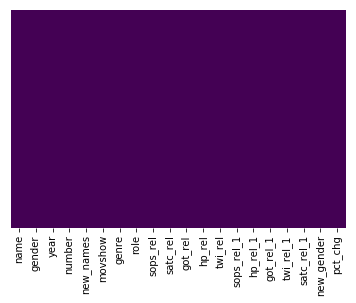

In [23]:
sns.heatmap(df_shows.isnull(), yticklabels=False, cbar=False, cmap="viridis")

#### EDA: Create a function that visualizes character name popularity to get an idea of which names become popular and when

In [24]:
def plot_yearly_count(character_name):
    data_agg=df_shows[df_shows["name"]==character_name].groupby(["year"],as_index=False).agg({"number": "sum"})
    if len(data_agg)==0:
        print('(Un)fortunately, there is no data for the name '+str(character_name)+' at this time')
    else:
        year_df=pd.DataFrame()
        year_df["year"]=df_shows["year"].unique()
        data_agg["key"]=1
        data_agg=pd.merge(year_df,data_agg,on=["year"],how="left")
        data_agg=data_agg.sort_values("year",ascending=True)
        ax=data_agg.plot('year', 'number', kind='bar', figsize=(15,4), color='#afeeee', zorder=2, width=0.75)
        # Switch off ticks
        ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)
        # Set x-axis label
        ax.set_xlabel("Year", labelpad=20, size=12)
        # Set y-axis label
        ax.set_ylabel("# of Occurrences", labelpad=20, size=12)
        # Set title
        ax.set_title("Popularity of the name "+str(character_name)+" since 1970")
        ax.legend_.remove()

In [ ]:
'''for n in some_chars:
    plot_yearly_count(n)'''

In [ ]:
sops = ['Tony','Jennifer','Carmela','Christopher','Corrado','Sal','Silvio','Anthony','Meadow','Paulie','Livia','Salvatore','Paul','Olivia']
wire = ['Jimmy',"D'Angelo",'Cedric','Russell','Avon','Kima','Bunk','William','Ervin','Rhonda','Reginald','Lester','Frank','Nick','Beatrice','Spiros','Ellis','Thomas','Preston','Roland','Omar','Leander','Tommy','Howard','Marlo','Dennis','Clarence','Norman','Maurice','Clay','Chris','Michael','Duquan','Michael','Augustus','Scott','Alma']
brkbad = ['Walter','Skyler','Jesse','Hank','Marie','Saul','Gustavo','Mike','Lydia','Todd','Kimberly','Howard','Ignacio','Charles']
madmen = ['Don','Peggy','Pete','Betty','Joan','Salvatore','Paul','Ken','Harry','Rachel','Roger','Bert','Lane','Sally','Megan','Henry','Stan','Ted','Michael','Bobby']
seinfeld = ['Jerry','George','Elaine','Cosmo','Morty','Helen','Newman','Leo','Susan','Ruthie','Frank','Estelle']
frkgk = ['Harold','Jean','Lindsay','Sam','Daniel','Nick','Ken','Kim','Neal','Bill','Amy','Vicki','Gordon','Eli','Ben','Humphries','Millie','Cookie','Mark','Jeff','Maureen','Cindy','Sara','Todd','Sean','Harris','Alan']
got = ['Ned','Robert','Jaime','Catelyn','Cersei','Daenerys','Jorah','Viserys','Jon','Sansa','Arya','Robb','Theon','Bran','Joffrey','Sandor','Tyrion','Khal','Petyr','Davos','Samwell','Stannis','Melisandre','Jeor','Bronn','Verys','Varys','Shae','Margaery','Tywin','Talisa','Ygritte','Gendry','Tormund','Brienne','Ramsay','Gilly','Daario','Missandrei','Ellaria','Tommen','Jaqen','Roose','Khaleesi']
curb = ['Jeff','Cheryl','Larry','Susie','Christine','Richard','Julia','Ted','Sammi','Nat','Leon','Marty','Matt','Antoinette']
friends = ['Rachel','Joey','Joseph','Phoebe','Chandler','Ross','Monica']
buffy = ['Buffy','Spike','Angel','Xander','Rupert','Faith','Dawn','Cordelia','Tara','Anya','Drusilla','Riley','Oz','Darla','Wesley','Joyce','Jenny','Caleb','Jonathan','Kendra']
starwars = ['Han','Leia','Luke','Darth','Yoda','Kylo','Obi-Wan','Rey','Finn','Anakin','Poe','Padme','Mace']
harrypotter = ['Harry','Ron','Hermione','Severus','Albus','Neville','Voldemort','Sirius','Draco','Bellatrix','Fred','George','Luna','Ginny']
lotr = ['Arwen','Eowyn','Frodo','Gollum','Gandalf','Aragorn','Legolas','Samwise','Bilbo','Gimli','Galadriel']
twilight = ['Bella','Jacob','Edward','Alice','Rosalie','Jasper','Carlisle','Emmett','Esme','Renee','Renesmee']

#titles = [sops, wire, brkbad, madmen, seinfeld, frkgk, got, curb, friends, buffy, starwars, harrypotter, lotr, twilight]

#not SNL or twilight zone or the Daily Show or Late Night with David Letterman or The Larry Sanders Show

#### Subdivide the dataset to get a look at names after 1995

In [25]:
df_shows_new = df_shows[df_shows['year']>=1995]

#### Describe both dataframes

In [26]:
df_shows.describe()

,year,number,new_names,movshow,genre,role,sops_rel,satc_rel,got_rel,hp_rel,twi_rel,sops_rel_1,hp_rel_1,got_rel_1,twi_rel_1,satc_rel_1,new_gender,pct_chg
count,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000
mean,1993.935333,4559.26400,16.047333,0.514667,0.279333,0.202667,0.242667,0.112000,0.142667,0.263333,0.059333,0.049333,0.043333,0.032667,0.020000,0.03800,0.554667,32.148412
std,13.481307,9562.51007,9.448913,1.255456,0.627350,0.525779,1.206959,0.691695,0.850958,1.398318,0.458934,0.216635,0.203674,0.177822,0.140047,0.19126,0.497168,238.244250
min,1971.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.999799
25%,1982.000000,52.00000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.081446
50%,1994.000000,633.50000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,2005.000000,2992.25000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.052022
max,2017.000000,60023.00000,31.000000,5.000000,2.000000,2.000000,9.000000,6.000000,7.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,4458.600000


In [27]:
df_shows_new.describe()

,year,number,new_names,movshow,genre,role,sops_rel,satc_rel,got_rel,hp_rel,twi_rel,sops_rel_1,hp_rel_1,got_rel_1,twi_rel_1,satc_rel_1,new_gender,pct_chg
count,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000,722.000000
mean,2006.023546,4088.519391,15.740997,1.069252,0.580332,0.421053,0.504155,0.232687,0.296399,0.547091,0.123269,0.102493,0.090028,0.067867,0.041551,0.078947,0.530471,38.044000
std,6.660439,7277.633418,9.155656,1.638027,0.802078,0.694739,1.701956,0.983151,1.208253,1.977298,0.655743,0.303506,0.286420,0.251692,0.199700,0.269844,0.499417,312.327569
min,1995.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.999799
25%,2000.000000,61.250000,7.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.084945
50%,2006.000000,586.500000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2012.000000,3318.000000,25.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.063550
max,2017.000000,36014.000000,31.000000,5.000000,2.000000,2.000000,9.000000,6.000000,7.000000,11.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4458.600000


#### Looks like it's the supporting characters and fantasy characters that display stronger rises during years of popularity

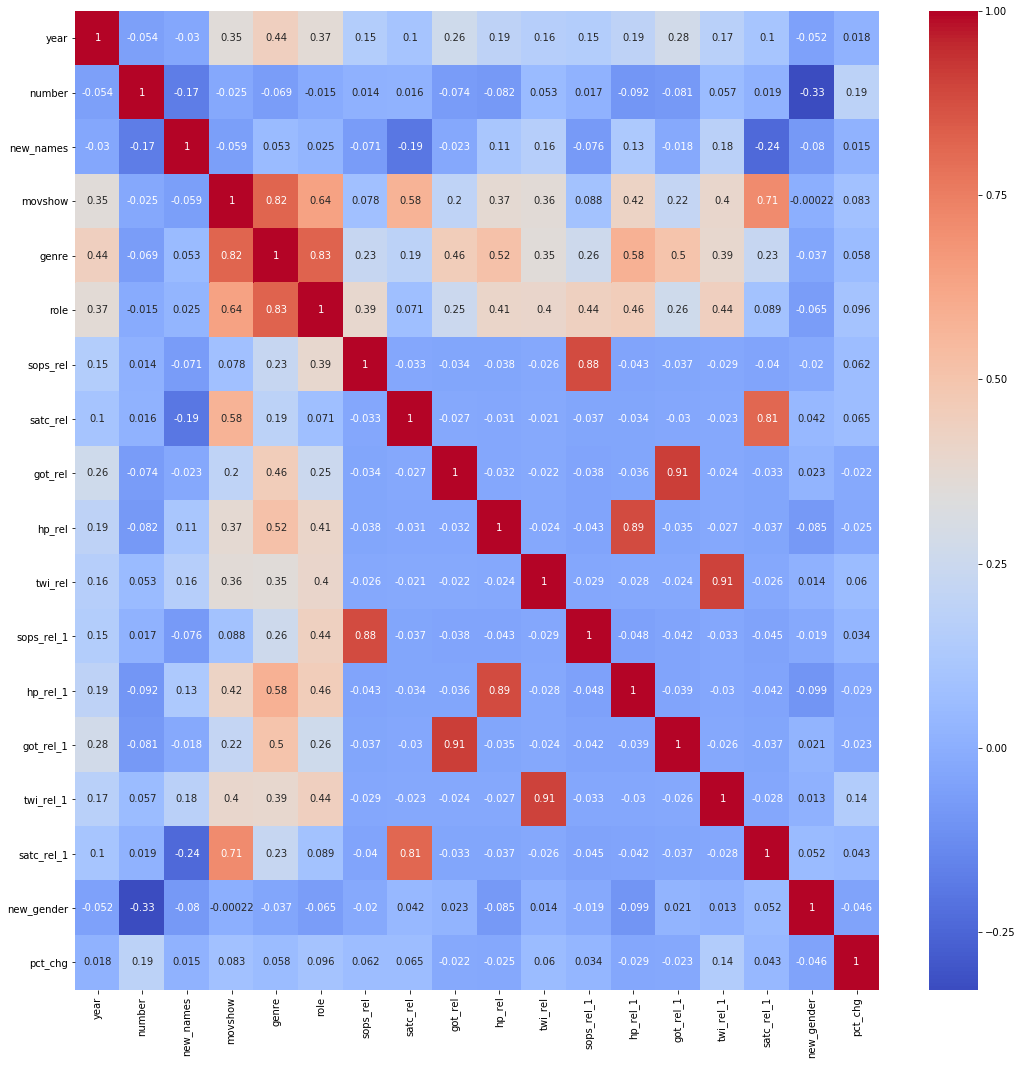

In [28]:
plt.subplots(figsize=(18,18))
sns.heatmap(df_shows.corr(), annot=True, cmap="coolwarm")

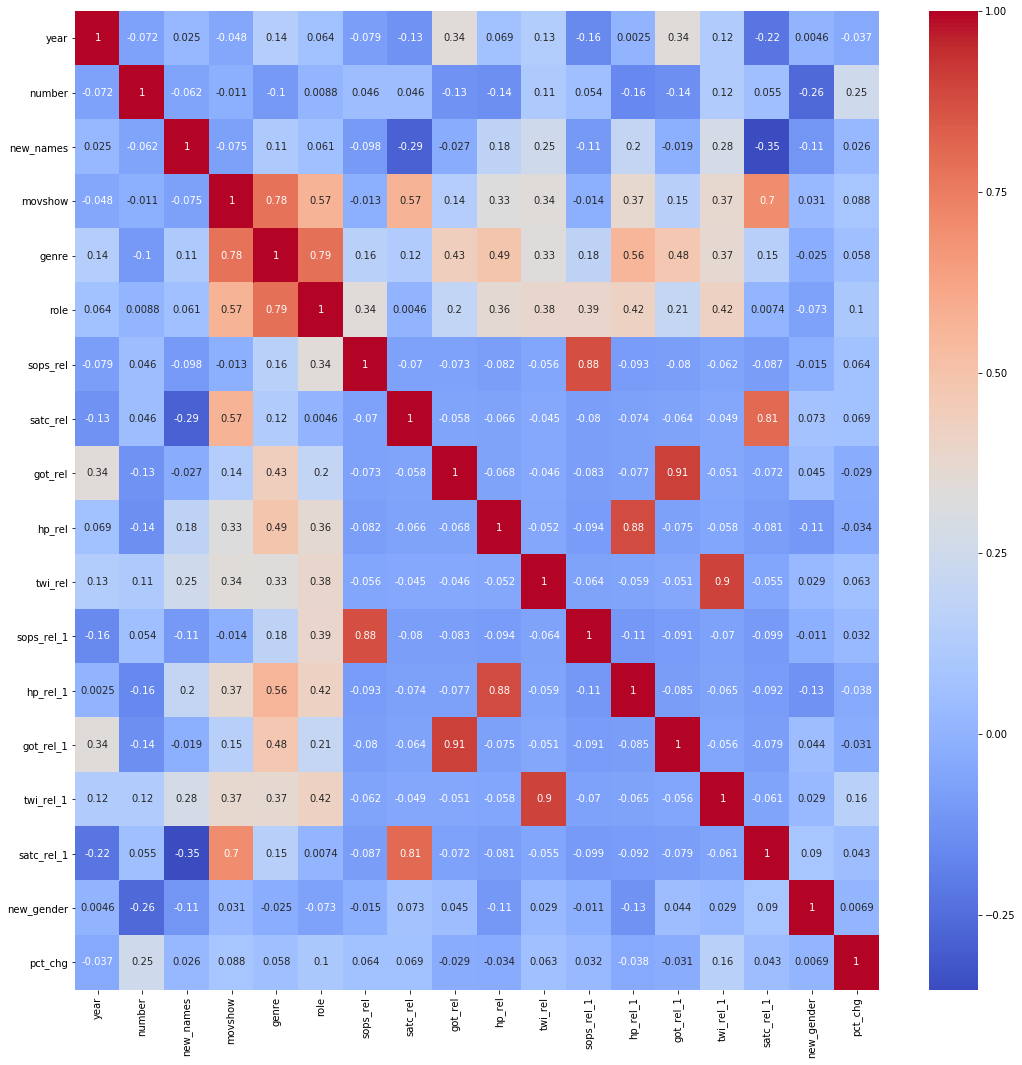

In [52]:
plt.subplots(figsize=(18,18))
sns.heatmap(df_shows_new.corr(), annot=True, cmap="coolwarm")

In [29]:
df_shows.shape

(1500, 20)

In [30]:
df_shows_new.shape

(722, 20)

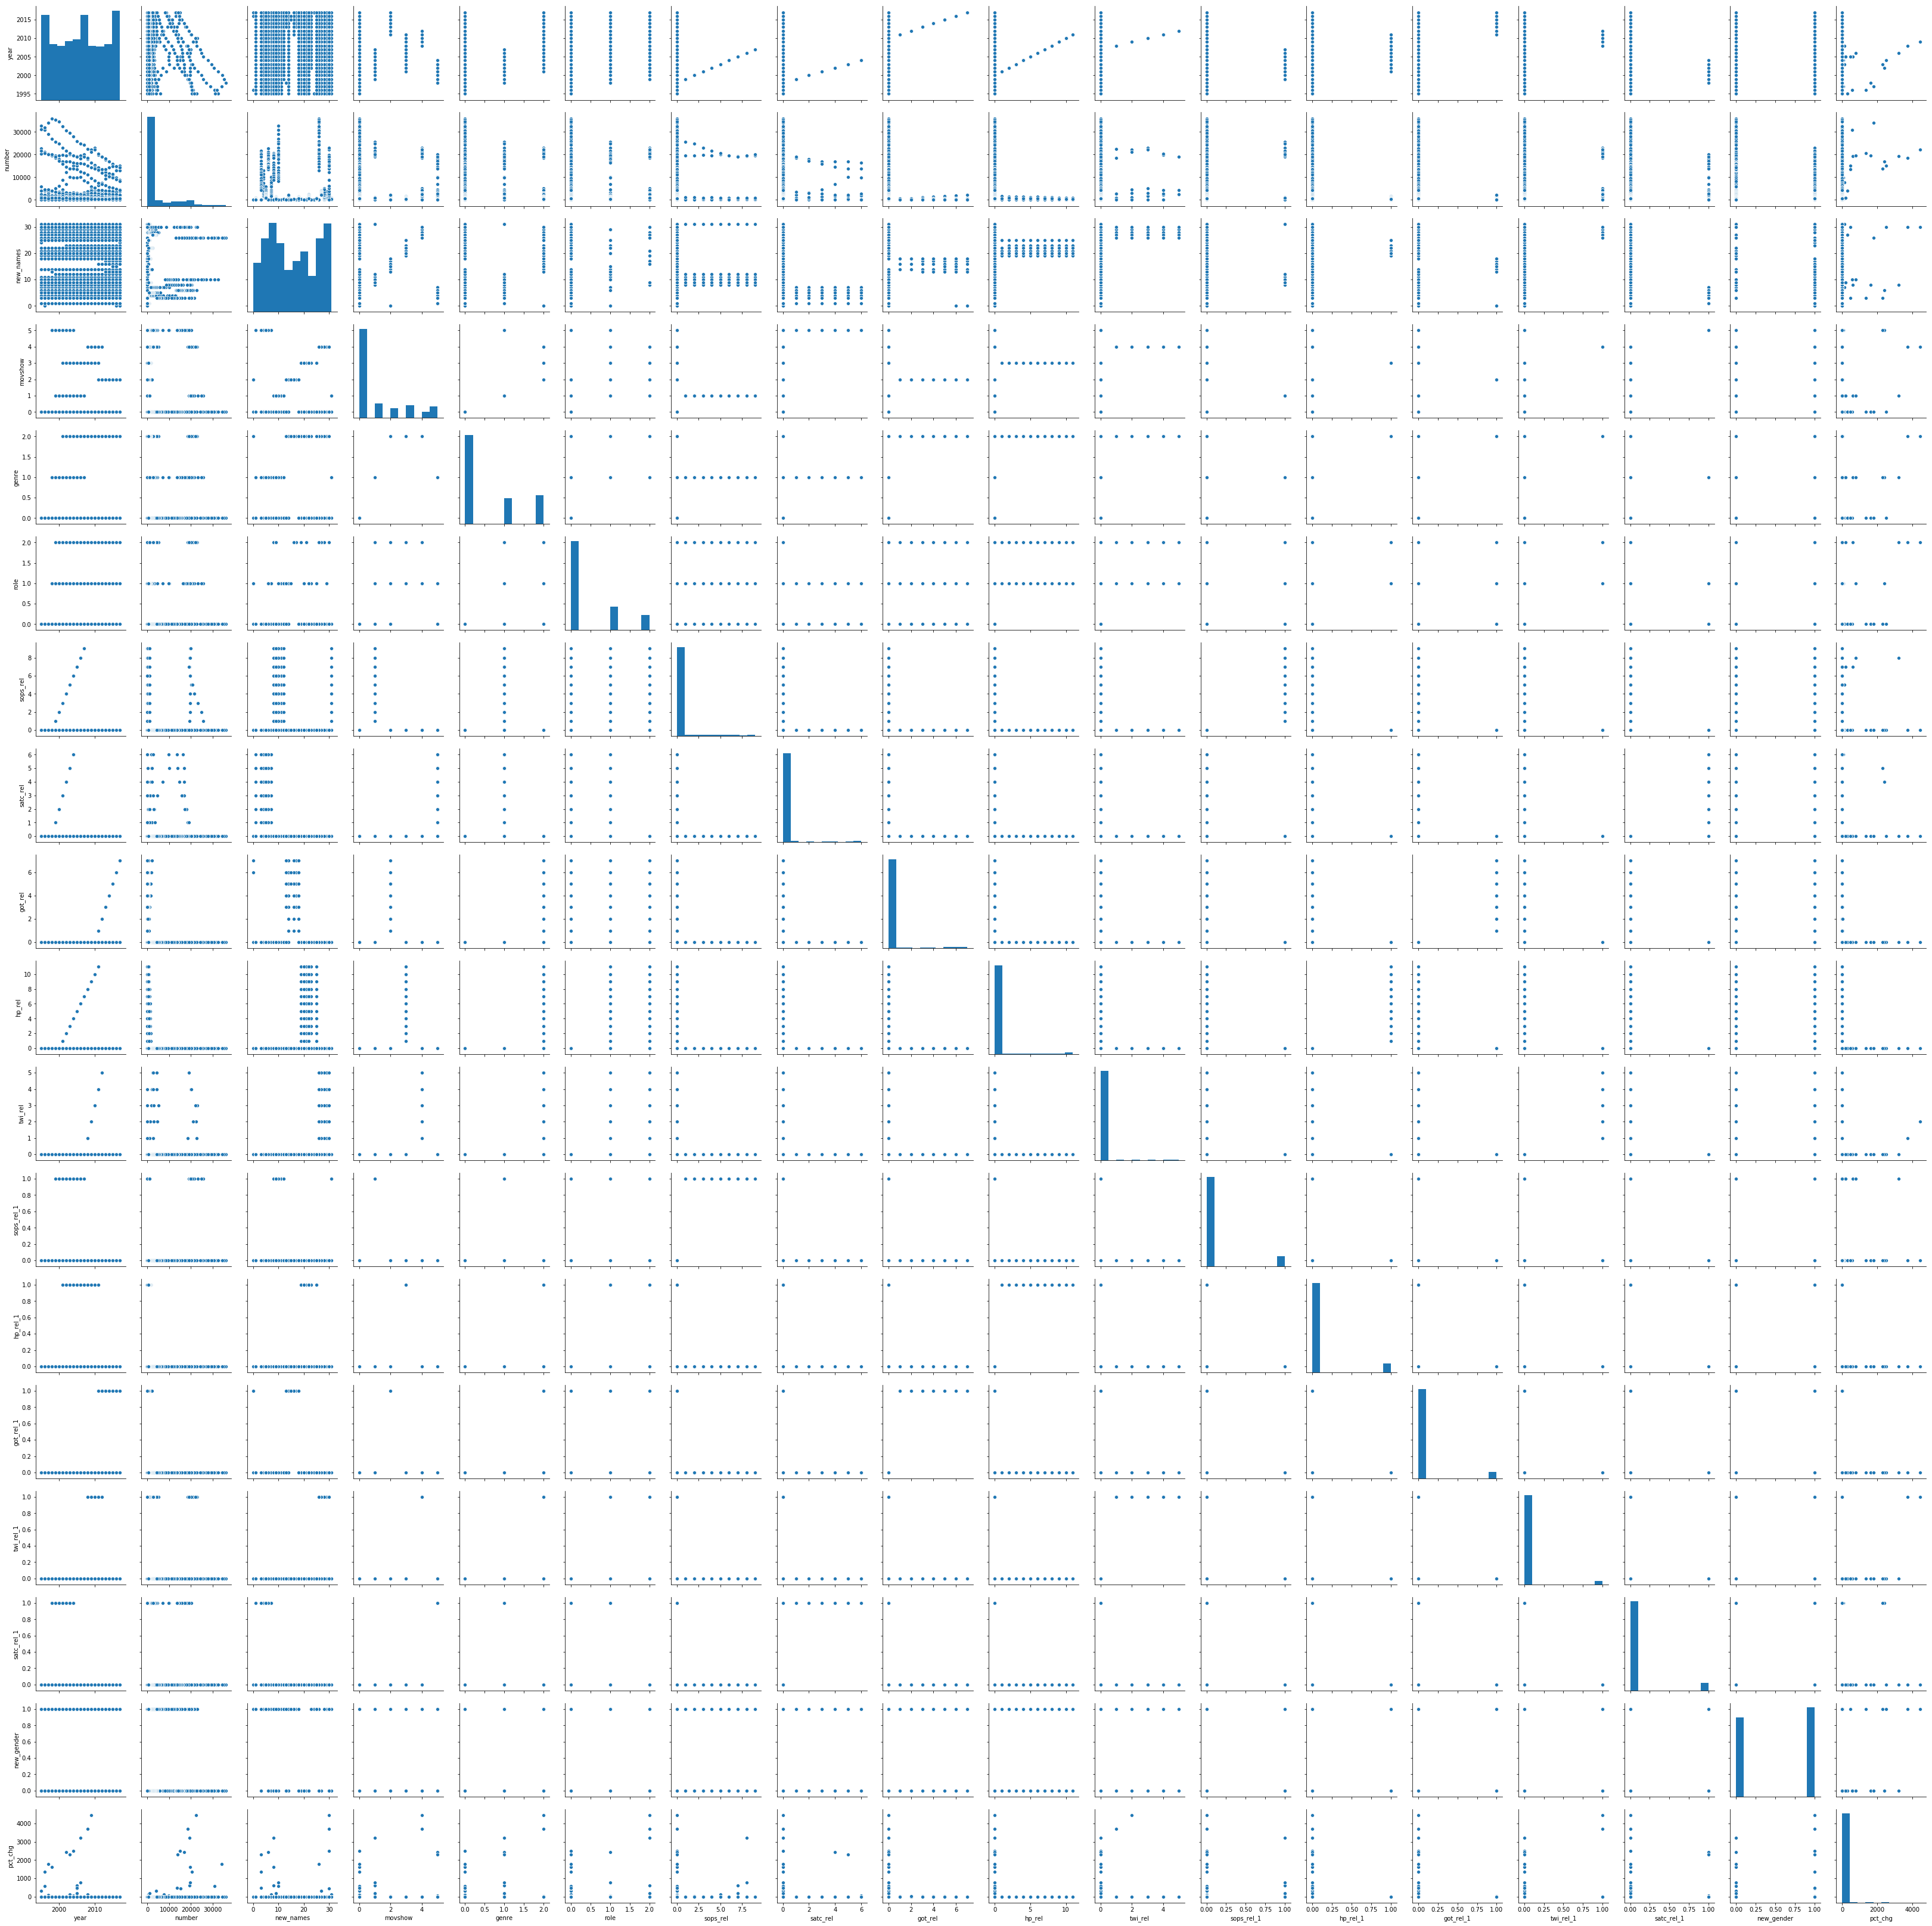

In [32]:
sns.pairplot(df_shows_new)

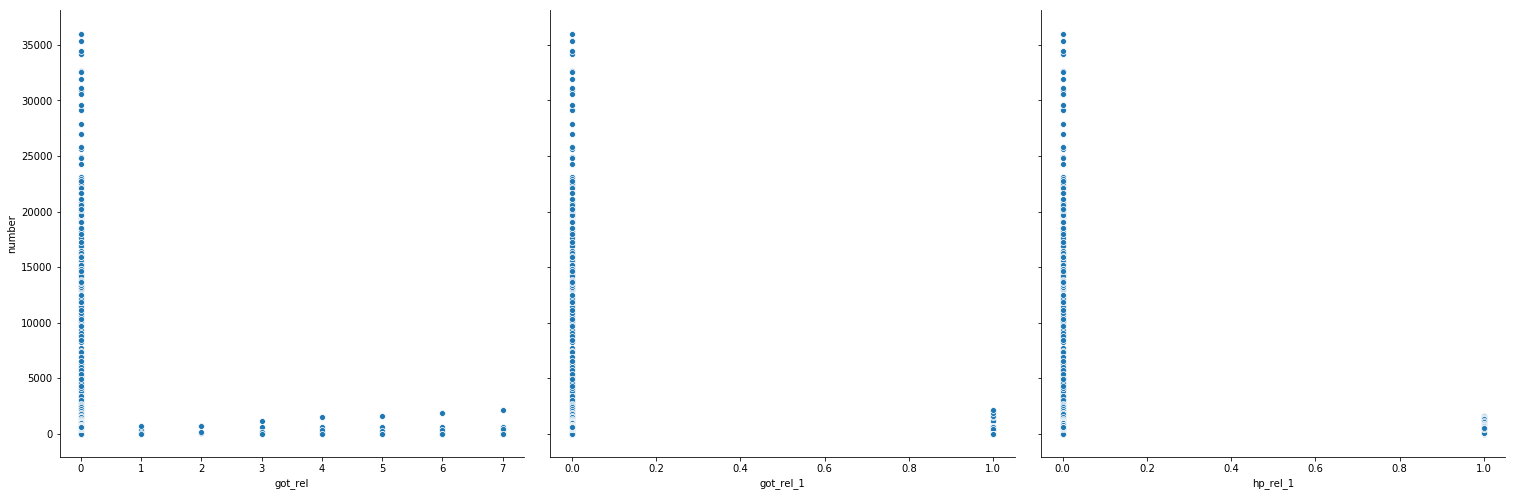

In [33]:
sns.pairplot(df_shows_new,y_vars=['number'],x_vars=['got_rel','got_rel_1','hp_rel_1'],height=7)

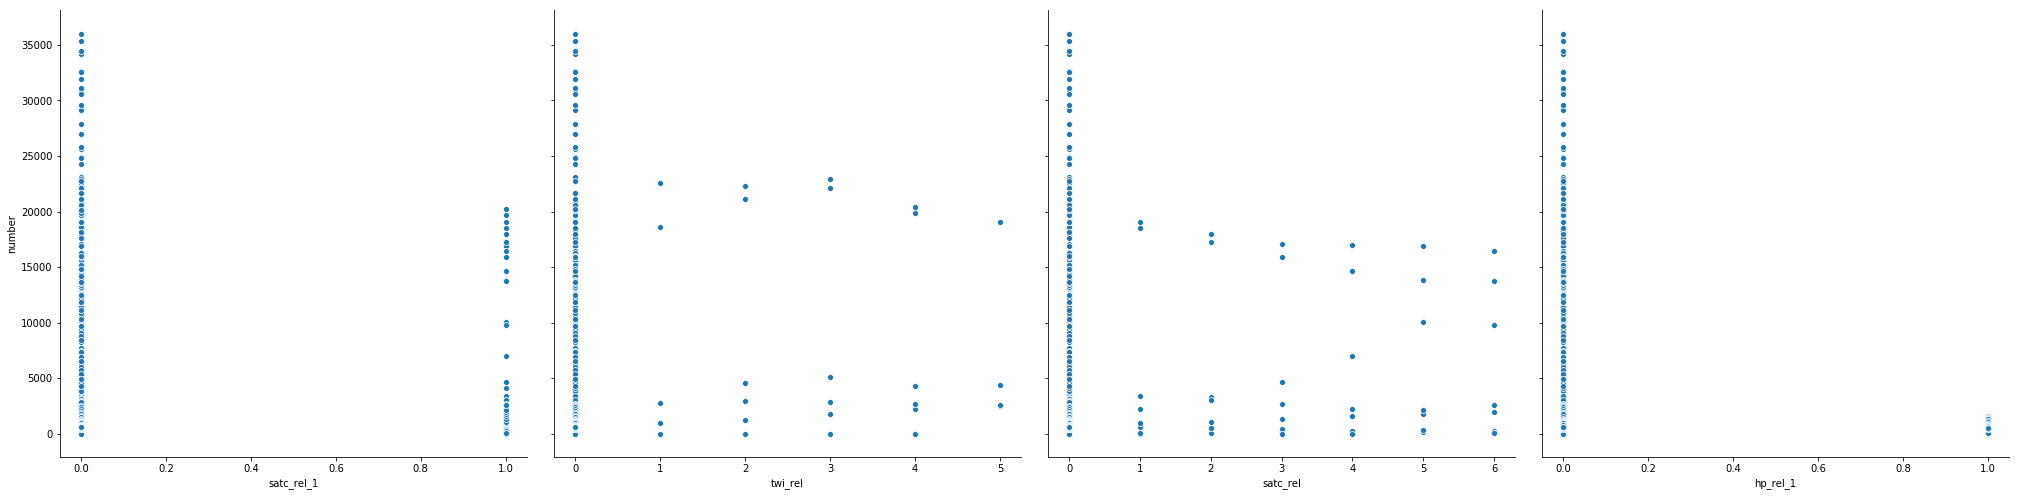

In [34]:
sns.pairplot(df_shows_new,y_vars=['number'],x_vars=['satc_rel_1','twi_rel','satc_rel','hp_rel_1'],height=7)

In [ ]:
def plot_yearly_count(character_name):
    data_agg=df_shows[df_shows["name"]==character_name].groupby(["year"],as_index=False).agg({"number": "sum"})
    if len(data_agg)==0:
        print('(Un)fortunately, there is no data for the name '+str(character_name)+' at this time')
    else:
        year_df=pd.DataFrame()
        year_df["year"]=df_shows["year"].unique()
        data_agg["key"]=1
        data_agg=pd.merge(year_df,data_agg,on=["year"],how="left")
        data_agg=data_agg.sort_values("year",ascending=True)
        ax=data_agg.plot('year', 'number', kind='bar', figsize=(17,5), color='#afeeee', zorder=2, width=0.75)
        # Switch off ticks
        ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)
        # Set x-axis label
        ax.set_xlabel("Year", labelpad=20, size=12)
        # Set y-axis label
        ax.set_ylabel("# of Occurrences", labelpad=20, size=12)
        # Set title
        ax.set_title("Popularity of the name "+str(character_name)+" since 1970")
        ax.legend_.remove()

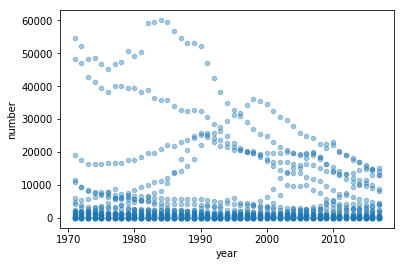

In [38]:
df_shows.plot(kind='scatter', x='year', y='number', alpha=0.4)

## Start the model
#### Import libraries

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
X = df_shows_new.drop(['number','name','gender'],axis=1)
y = df_shows_new['number']

In [ ]:
#Start with a 70/30 split
X_train, X_test, y_train, y_test = tts(X, y, test_size=.3, random_state=42)

In [ ]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
#Predict
y_pred = lr.predict(X_test)

In [ ]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Really bad. Trying different variables for X and y

In [ ]:
X = df_shows_new.drop(['new_names','name','gender'],axis=1)
y = df_shows_new['new_names']

In [ ]:
#Start with a 70/30 split
X_train, X_test, y_train, y_test = tts(X, y, test_size=.3, random_state=42)

In [ ]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
#Predict
y_pred = lr.predict(X_test)

In [ ]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Better, but try a different test size

In [ ]:
#Try a 90/10 split
X_train, X_test, y_train, y_test = tts(X, y, test_size=.1, random_state=42)

In [ ]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
#Predict
y_pred = lr.predict(X_test)

In [ ]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Not better than 70/30. Try 60/40

In [ ]:
#Try a 60/40 split
X_train, X_test, y_train, y_test = tts(X, y, test_size=.4, random_state=42)

In [ ]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
#Predict
y_pred = lr.predict(X_test)

In [ ]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### 60/40 looks best

## Try k-fold cross validation

In [ ]:
#Instantiate
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [ ]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

#### Try with 10 folds

In [ ]:
#Instantiate
kfolds = model_selection.KFold(n_splits=10, shuffle=True)

In [ ]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kfolds.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

#### Looks like 5 folds is best of the two

In [ ]:
# Create a custom colormap
cmap = ListedColormap(['#26ff00', '#00bbff', '#aa00ff'])

In [ ]:
#Create a scatterplot of number versus year and color by genre
sns.scatterplot(x = df_shows_new['year'], y = df_shows_new['number'], hue = df_shows_new['genre'], cmap = cmap)

In [ ]:
#Instantiate
knn = KNeighborsClassifier(n_neighbors = 1)

#Fit
knn.fit(X_train, y_train)

#predict
pred = knn.predict(X_test)

#Score
knn.score(X_test, y_test)

In [ ]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(knn.score(X_test, y_test))

In [ ]:
#Instantiate
knn = KNeighborsClassifier(n_neighbors = 5)

#Fit
knn.fit(X_train, y_train)

#predict
pred = knn.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(knn.score(X_test, y_test))

In [ ]:
df_thrones = df_shows_new[df_shows_new['name'].isin(got)]
df_thrones = df_thrones.drop([#'name',
 #'gender',
 #'year',
 #'number',
 'movshow',
 'genre',
 #'role',
 'sops_rel',
 'satc_rel',
 #'got_rel',
 'hp_rel',
 'twi_rel',
 'sops_rel_1',
 'hp_rel_1',
 #'got_rel_1',
 'twi_rel_1',
 'satc_rel_1',
 #'pct_chg',
 #'new_names',
 #'new_gender'
],axis=1)

In [ ]:
got_dict = {'Brienne':0,'Tyrion':1,'Arya':2,'Sansa':3,'Khaleesi':4,'Daenerys':5,'Jaime':6}
df_thrones['new_names'] = df_thrones['name'].map(got_dict)

In [ ]:
df_thrones.head()

In [ ]:
df_thrones.shape

In [ ]:
plt.subplots(figsize=(13,13))
sns.heatmap(df_thrones.corr(), annot=True, cmap="coolwarm")

In [ ]:
X = df_thrones.drop(['new_names','name','gender'],axis=1)
y = df_thrones['new_names']

In [ ]:
#Start with a 70/30 split
X_train, X_test, y_train, y_test = tts(X, y, test_size=.3, random_state=42)

In [ ]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
#Predict
y_pred = lr.predict(X_test)

In [ ]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Try a 90/10

In [ ]:
#Next, use a 90/10 split
X_train, X_test, y_train, y_test = tts(X, y, test_size=.1, random_state=42)

In [ ]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
#Predict
y_pred = lr.predict(X_test)

In [ ]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Drop to 60/40

In [ ]:
#Next, use a 90/10 split
X_train, X_test, y_train, y_test = tts(X, y, test_size=.4, random_state=42)

In [ ]:
# Instantiate and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
#Predict
y_pred = lr.predict(X_test)

In [ ]:
#Score
print('MSE: ', metrics.mean_squared_error(y_train, lr.predict(X_train)))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#### Try K-folds

In [ ]:
#Instantiate
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [ ]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

#### Try 10 folds

In [ ]:
#Instantiate
kfolds = model_selection.KFold(n_splits=10, shuffle=True)

In [ ]:
mse_values = []
scores = []
n = 0

print("~~~~ CROSS VALIDATION each fold ~~~~")
for train_index, test_index in kfolds.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index])))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('MSE: {}'.format(mse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))


print("~~~~ SUMMARY OF CROSS VALIDATION ~~~~")
print('Mean of MSE for all folds: {}'.format(np.mean(mse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

In [ ]:
X = df_shows_new.drop(['new_names','name','gender'],axis=1)
y = df_shows_new['new_names']

In [ ]:
#Train test split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

##Instantiate
dtree = DecisionTreeClassifier()

#Fit
dtree.fit(X_train, y_train)

#predict
dt_pred = dtree.predict(X_test)

In [ ]:
#evaluate
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,dt_pred))

In [ ]:
print(confusion_matrix(y_test, dt_pred))

In [ ]:
from sklearn.metrics import precision_score
print("Precision score: {}".format(precision_score(y_train,y_pred)))

In [50]:
# Create X and y
X = pd.DataFrame()
X = df_shows['got_rel_1']
y = df_shows.number

In [51]:
print((type(X)))
print((type(X.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [47]:
X.shape

(1500,)

In [48]:
y.shape

(1500,)

In [57]:
feature_cols = ['twi_rel_1']
X = df_shows_new[feature_cols]
y = df_shows_new.number

In [58]:
print((type(X)))
print((type(X.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [59]:
X.shape

(722, 1)

In [60]:
y.shape

(722,)

In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
# Make an instance of a LinearRegression object.
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

In [63]:
# help(lr)
lr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [64]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [66]:
dict(zip(lr.coef_,X.columns))

{4490.847591522158: 'twi_rel_1'}

In [67]:
# Per future warning, one-dimensional arrays must be reshaped using the following.
lr.predict(np.array([0]).reshape(1,-1))

array([3901.91907514])

In [68]:
X_new = [[0], [10]]
lr.predict(X_new)

array([ 3901.91907514, 48810.39499037])

In [69]:
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [70]:
print(linreg.intercept_)
print(linreg.coef_)

3901.9190751445085
[4490.84759152]
